In [2]:
import math

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

%matplotlib inline
sns.set_style('white')

# Test Statistics

There are two main aspects of a regression model we can evaluate using significance testing:
1. Whether the model, as a whole, explains more variance in outcome than a model with no features
2. Whether each individual feature in the model adds explanatory power.

## Whole Model: F-test

An F-test is used to compare 2 populations’ variances. The samples can be any size. It is the basis of ANOVA.

F-tests test the explantory power of the whole model.  **F-tests principally represents the ratio between the unexplained variance of your model and the unexplained variance of a reduced model to which our model is compared.**  

Here, *reduced model* means a model with no features, meaning all variance in the outcome is unexplained.

For a linear regression model with two parameters $y=\alpha+\beta x$, the F-test is built from these pieces:

* unexplained model variance:

$$SSE_F=\sum(y_i-\hat{y}_i)^2$$

* unexplained variance in reduced model:

$$SSE_R=Var_y = \sum(y_i-\bar{y})^2$$

 * number of parameters in the model:

$$p_F = 2 (\alpha \text{ and } \beta)$$

 * number of parameters in the reduced model:

$$p_R = 1 (\alpha)$$

 * number of datapoints:

$$n$$

 * degrees of freedom of $SSE_F$:

$$df_F = n - p_F$$

 * degrees of freedom of $SSE_R$:

$$df_R = n - p_R$$

These pieces come together to give us the full equation for the F-test:

$$F=\dfrac{SSE_F-SSE_R}{df_F-df_R}÷\dfrac{SSE_F}{df_F}$$

A **parameter** is any predictor in a regression model, including both the intercept and the features.   **Degrees of freedom** quantify the amount of information "left over" to estimate variability after all parameters are estimated.

In regression, degrees of freedom for a function works like this:  With two datapoints, a regression line $y=\alpha + \beta x$ has 0 degrees of freedom (2 minus the number of parameters).  Those two parameters encompass all the information in the data.  Knowing $\alpha$ and $\beta$ alone, we can perfectly reproduce the original data.  No additional information is available from the data itself.

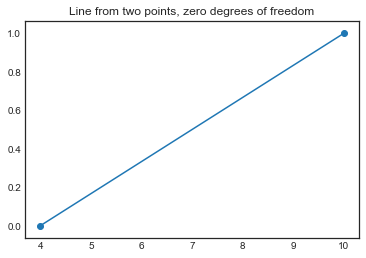

In [3]:
y = [0, 1]
x = [4, 10]
plt.scatter(x, y)
plt.plot(x, y)
plt.title("Line from two points, zero degrees of freedom")
plt.show()

If we add another datapoint and fit a new model with the same number of parameters, we have 1 defree of freedom.  In order to perfectly reproduce the data, we would need to know $\alpha$, $\beta$, *and* the value of one of the datapoints.  We have one point of free information not captured by the model

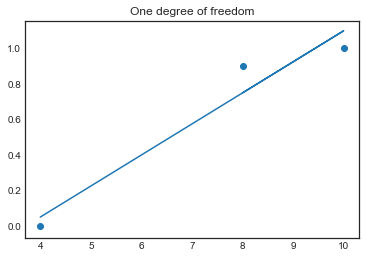

In [4]:
y=[0, 1, .9]
x=[4, 10, 8]
plt.scatter(x, y)
plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x))
plt.title("One degree of freedom")
plt.show()

Low degrees of freedom can mean there is overfitting or a very small sample.

An F-test has two degrees of freedom indicators: One for the model ($p-1$) and the degrees of freedom of $SSE_F$ ($n-p_F$).  These degrees of freedom define the F-distribution for that F-test value.  The location of the F-test value within the F-distribution determines the p-value - The probability of getting an F-test of that value or higher if there were no relationship between the outcome and the parameters of the population. A significant (usually $\alpha < .05$) p-value suggests that the model as a whole can explain some of the variance in the outcome.

In other words, the F-test tests whether the $R^2$ of the model is different from zero.  A non-significant F-test is a sign that your model is unable to predict the outcome and you need to make a new one.

But an F-test does not guarantee that all the parameters in the model will be significant.  If there is high collinearity, it is possible to get a significant F-test without any statistically significant features.

We need to test individual parameters separately with t-tests to evaluate their performance in the model.

### Individual parameters: t-test

Once you have a significant F-test, the next step in evaluating a model is to learn more about the performance of the *individual parameters*, particularly the features you introduced.  Each of the parameters in a model has its own statistical test, a **t-test**, that *determines whether that parameter estimate is significantly different from zero*, and therefore explains a statistically-significant amount of *unique* variance in the outcome, *after controlling for the variance explained by the other parameters*.  A non-significant parameter can be discarded with little to no decrease in the model's explanatory power as quantified by $R^2$.

Let's use the toy advertising example!


In [3]:
# Read data into a DataFrame.
data_url = 'https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/Advertising.csv'
data = pd.read_csv(data_url, index_col=0)
data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


The `LinearRegression` function from `scikit-learn` is focused on machine learning prediction rather can statistical interpretation, so it is hard to extract p-values for each parameter of the model. 

Instead, we can use `statsmodels`, a primary alternative to `sci-kit learn` that offers many of the same models with slightly different syntax and formatting.  You can also easily get the p-values in linear regression models using the `statsmodel ols` function.

In [12]:
# Write out the model formula.  Similar to R syntax!
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form
linear_formula = 'Sales ~ TV+Radio+Newspaper'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=data).fit()

Now we can look at the coefficients of the parameters

In [13]:
lm.params

Intercept    2.938889
TV           0.045765
Radio        0.188530
Newspaper   -0.001037
dtype: float64

And we can look at the pvalues of each coefficient.

In [14]:
lm.pvalues

Intercept    1.267295e-17
TV           1.509960e-81
Radio        1.505339e-54
Newspaper    8.599151e-01
dtype: float64

And lastly, $R^2$.

In [15]:
lm.rsquared

0.89721063817895219

From the p-values, we see the p-value for Newspaper is greater than .05, suggesting that there is probably no effect for that feature – and that dropping it would not adversely affect the $R^2$.

### Drill: dropping features and re-fitting
Since the p-value for Newspaper indicates that it probably has no effect, try re-fitting the model without the Newspaper feature. How much does the R^2 change? Do the other parameters change?

In [16]:
linear_formula = 'Sales ~ TV+Radio'
lm2 = smf.ols(formula=linear_formula, data=data).fit()

In [17]:
lm2.params

Intercept    2.921100
TV           0.045755
Radio        0.187994
dtype: float64

There is some change in the parameters, but not significantly.  

In [18]:
lm2.rsquared

0.89719426108289557

$R^2$ is essentially the same.

## Confidence Intervals

`statsmodel` can also give us **confidence intervals**, the range of calues within whuch our population parameter is likely to fall.
A 95% confidence interval, the defauly value in most stats packages, says that if we re-sample this population over and over again, 95% of the time out estimates for that parameter would fall within that intercal.  
We can use this information to estimate the confience intercal for our predicted value so we not only know what value we expect, but with what level of certainrt we can expect it.

In [19]:
lm.conf_int()

,0,1
Intercept,2.323762,3.554016
TV,0.043014,0.048516
Radio,0.171547,0.205513
Newspaper,-0.012616,0.010541


'0' is the lower bound and '1' is the upper bound of the confidence interval.  

A confidence interval that contains 0 is a sign that the parameter is not explaining significant variance in the outcome. The wider the confidence intervals are, the more uncertainty there is about the model estimates.

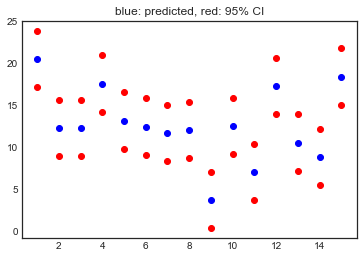

In [22]:
# Use wls_prediction_std to build confidence intervals
prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure()

# Plot upper bound of confidence intervals
plt.plot(iv_u[0:15], 'o', color='r')

# Plot lower bound of confidence intervals
plt.plot(iv_l[0:15], 'o', color='r')

# Plot prediected values
plt.plot(lm.fittedvalues[0:15], 'o', color='b')

plt.title('blue: predicted, red: 95% CI')
plt.show()